<a href="https://colab.research.google.com/github/ThienNguyen3001/Stock-Price-Prediction-LSTM-RNN/blob/main/stock_price_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!git clone https://github.com/ThienNguyen3001/Stock-Price-Prediction-LSTM-RNN.git
%cd Stock-Price-Prediction-LSTM-RNN
!pip3 install d2l

In [2]:
!pwd

/content/Stock-Price-Prediction-LSTM-RNN


In [3]:
import pandas as pd
import numpy as np
from numpy import zeros, newaxis

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from d2l import torch as d2l

from sklearn.preprocessing import MinMaxScaler
import math, time
from math import sqrt
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

import statistics as st
import scipy as sc


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("suruchiarora/yahoo-finance-dataset-2018-2023")

print("Path to dataset files:", path)

100%|██████████| 77.5k/77.5k [00:00<00:00, 47.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/suruchiarora/yahoo-finance-dataset-2018-2023/versions/1


In [5]:
df = pd.read_excel(r'/root/.cache/kagglehub/datasets/suruchiarora/yahoo-finance-dataset-2018-2023/versions/1/yahoo_data.xlsx')
df

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Apr 28, 2023",33797.43,34104.56,33728.40,34098.16,34098.16,354310000
1,"Apr 27, 2023",33381.66,33859.75,33374.65,33826.16,33826.16,343240000
2,"Apr 26, 2023",33596.34,33645.83,33235.85,33301.87,33301.87,321170000
3,"Apr 25, 2023",33828.34,33875.49,33525.39,33530.83,33530.83,297880000
4,"Apr 24, 2023",33805.04,33891.15,33726.09,33875.40,33875.40,252020000
...,...,...,...,...,...,...,...
1253,"May 07, 2018",24317.66,24479.45,24263.42,24357.32,24357.32,307670000
1254,"May 04, 2018",23865.22,24333.35,23778.87,24262.51,24262.51,329480000
1255,"May 03, 2018",23836.23,23996.15,23531.31,23930.15,23930.15,389240000
1256,"May 02, 2018",24097.63,24185.52,23886.30,23924.98,23924.98,385350000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1258 non-null   object 
 1   Open         1258 non-null   float64
 2   High         1258 non-null   float64
 3   Low          1258 non-null   float64
 4   Close*       1258 non-null   float64
 5   Adj Close**  1258 non-null   float64
 6   Volume       1258 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 68.9+ KB


In [7]:
df['Date'] = pd.to_datetime(df['Date'])

In [8]:
df.rename(columns={'Close*': 'Close', 'Adj Close**': 'Adj Close'}, inplace=True)

In [9]:
df.set_index('Date', inplace = True)

In [10]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,29595.823045,29776.945739,29402.432226,29599.361677,29599.361677,3.450636e+08
std,4006.078299,4009.007573,4004.949066,4007.468822,4007.468822,1.069142e+08
min,19028.360000,19121.010000,18213.650000,18591.930000,18591.930000,8.615000e+07
25%,26041.267500,26163.155000,25877.872500,26027.120000,26027.120000,2.773125e+08
50%,29201.410000,29335.685000,28996.500000,29199.460000,29199.460000,3.247250e+08
75%,33604.027500,33825.445000,33346.827500,33600.342500,33600.342500,3.875100e+08
max,36722.600000,36952.650000,36636.000000,36799.650000,36799.650000,9.159900e+08


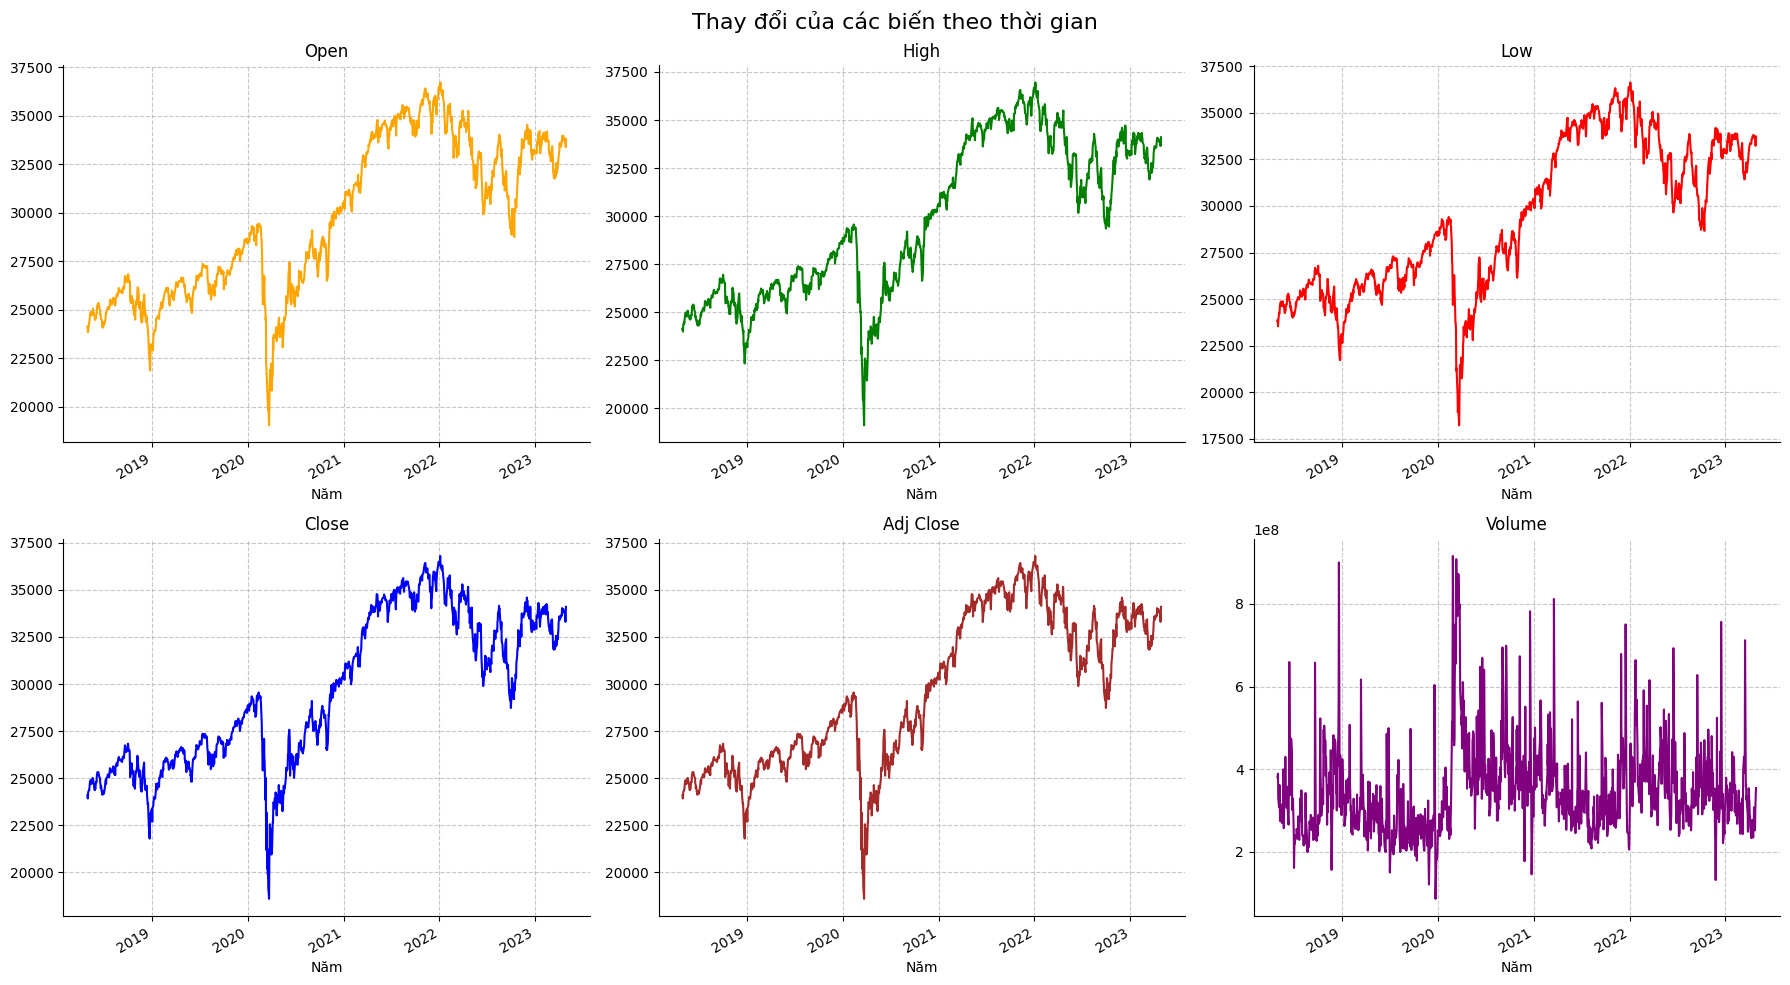

In [11]:
# Create figure and subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Thay đổi của các biến theo thời gian', fontsize=16)

# Plot price metrics
metrics = {
    (0,0): ('Open', 'orange', 'Open'),
    (0,1): ('High', 'green', 'High'),
    (0,2): ('Low', 'red', 'Low'),
    (1,0): ('Close', 'blue', 'Close'),
    (1,1): ('Adj Close', 'brown', 'Adj Close'),
    (1,2): ('Volume', 'purple', 'Volume')
}

# Create each subplot
for (row, col), (metric, color, title) in metrics.items():
    df[metric].plot(ax=axes[row,col], color=color)
    axes[row,col].set_title(title)
    axes[row,col].spines[['top', 'right']].set_visible(False)
    axes[row,col].grid(True, linestyle='--', alpha=0.7)
    axes[row,col].set_xlabel('Năm')

# Adjust layout
plt.tight_layout()
plt.show()

* Tất cả các biểu đồ ngoại trừ "Volume" đều có một dạng tương tự và đó là bởi vì sau giá mở cửa, thị trường chứng khoán thường có một biến động nhỏ lên xuống khiến cho các biểu đồ giá này tuân theo cùng một mô hình nhưng đối với cột "Volume" thì đây là một quá trình khá ngẫu nhiên đối với lượng giao dịch trong một ngày nhất định.

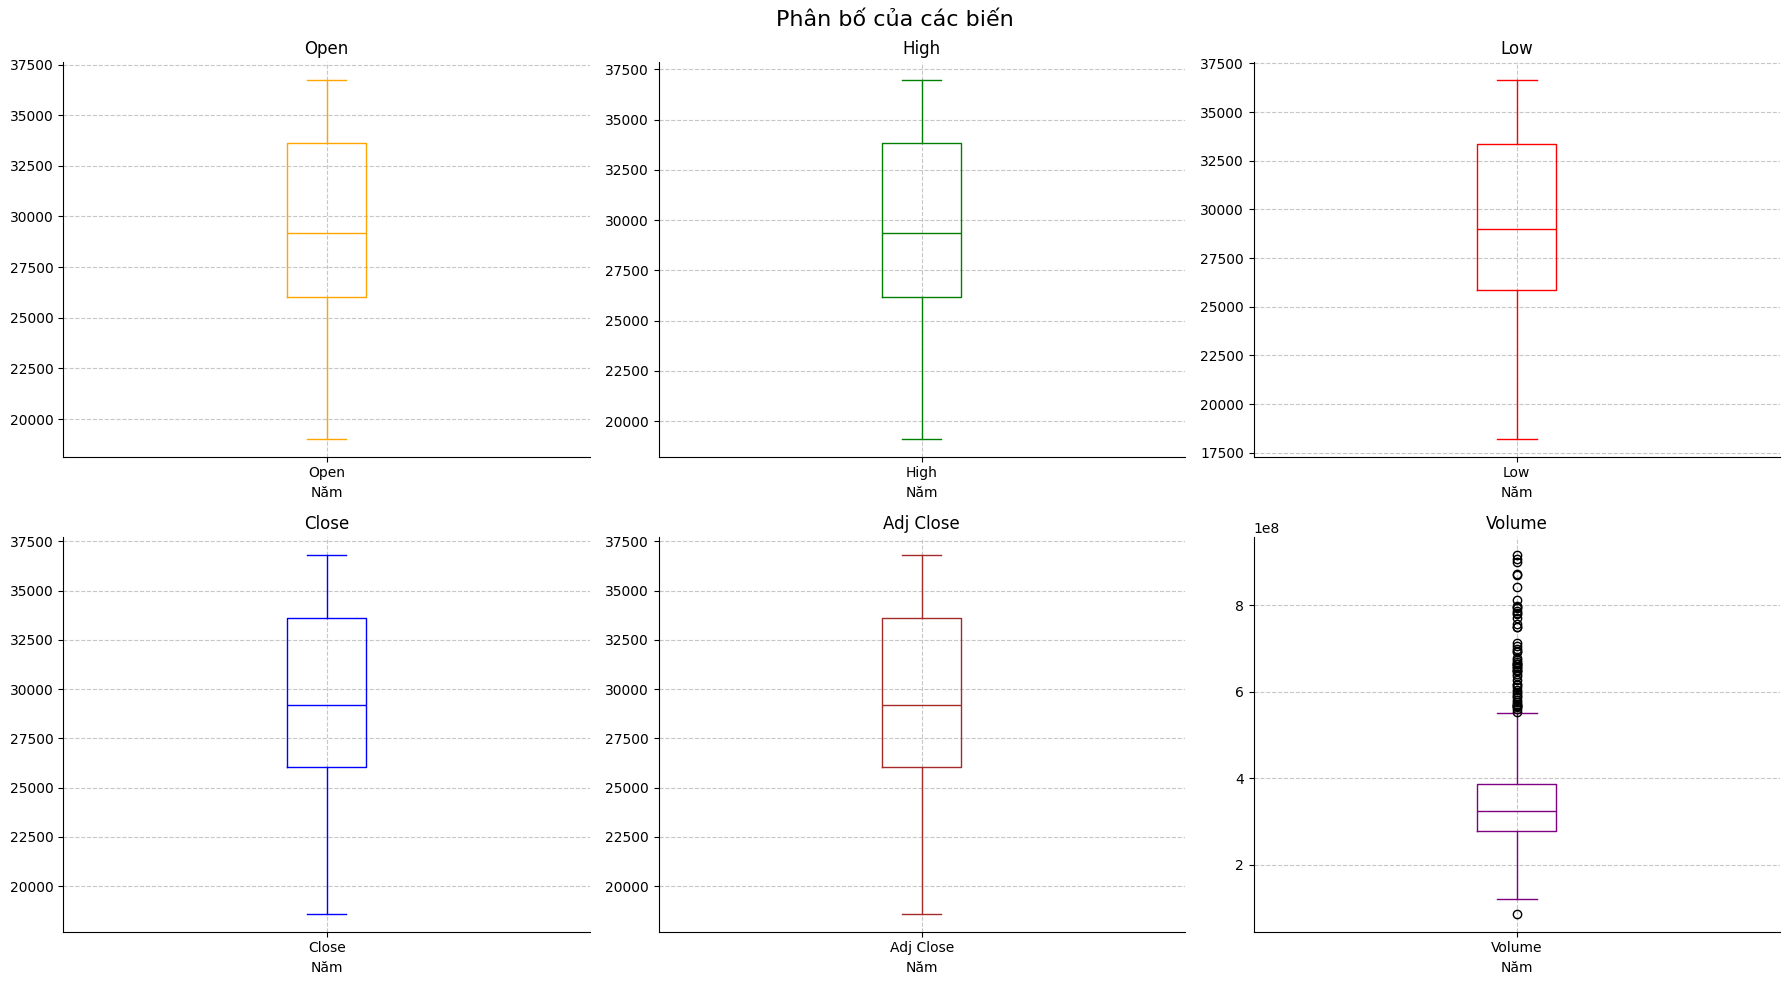

In [12]:
# Create figure and subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Phân bố của các biến', fontsize=16)

# Plot price metrics
metrics = {
    (0,0): ('Open', 'orange', 'Open'),
    (0,1): ('High', 'green', 'High'),
    (0,2): ('Low', 'red', 'Low'),
    (1,0): ('Close', 'blue', 'Close'),
    (1,1): ('Adj Close', 'brown', 'Adj Close'),
    (1,2): ('Volume', 'purple', 'Volume')
}

# Create each subplot
for (row, col), (metric, color, title) in metrics.items():
    df[metric].plot.box(ax=axes[row,col], color=color)
    axes[row,col].set_title(title)
    axes[row,col].spines[['top', 'right']].set_visible(False)
    axes[row,col].grid(True, linestyle='--', alpha=0.7)
    axes[row,col].set_xlabel('Năm')

# Adjust layout
plt.tight_layout()
plt.show()

* Đối với các biến về giá, có thể nhận thấy rằng nhìn chung chúng được phân bổ tốt nhưng biến "Volume" chứa một số giá trị ngoại lệ. Điều này được giải thích bởi thực tế là khi cổ phiếu giao dịch bắt đầu tăng thì giá trị giá giảm xuống, giải thích cho sự sụt giảm đột ngột về giá và "Volume" đạt đỉnh.

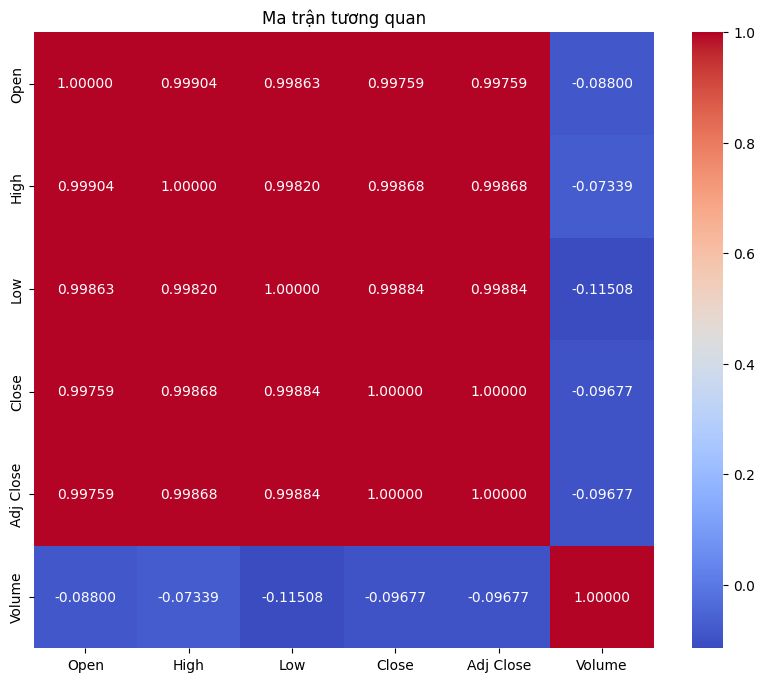

In [13]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".5f")
plt.title('Ma trận tương quan')
plt.show()

In [23]:
closing_price = df[['Close']]

window_size = 15 #14 input values and 15th value is the target

In [25]:
from src.split_data import split_data
#Preparing inputs
X_train, y_train, X_test, y_test, train_size, test_size = split_data(closing_price, window_size)

In [26]:
#Converting data to tensors for the model
X_train = torch.from_numpy(X_train).type(torch.Tensor)
X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train_rnn = torch.from_numpy(y_train).type(torch.Tensor)
y_test_rnn = torch.from_numpy(y_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [27]:
from src.rnn import RNN

In [28]:
#Model specifics
num_input, num_hidden, num_layer, num_output = 1, 4, 1, 1
rnn_model = RNN(num_input, num_hidden, num_layer, num_output)

In [20]:
#Loss and optimiser functions
num_epochs, lr = 100, 0.1
rnn_criterion = nn.MSELoss(reduction = 'mean')
rnn_updater = torch.optim.Adam(rnn_model.parameters(), lr = lr)

In [29]:
#Training RNN model
train_hist_rnn = np.zeros(num_epochs)

for epoch in range(num_epochs):
    y_train_pred_rnn = rnn_model(X_train)

    loss = rnn_criterion(y_train_pred_rnn, y_train_rnn)
    train_hist_rnn[epoch] = loss.item()
    if epoch % 5 == 0:
      print("Epoch ", epoch, "MSE: ", loss.item())
    rnn_updater.zero_grad()
    loss.backward()
    rnn_updater.step()

Epoch  0 MSE:  0.21482597291469574
Epoch  5 MSE:  0.21482597291469574
Epoch  10 MSE:  0.21482597291469574
Epoch  15 MSE:  0.21482597291469574
Epoch  20 MSE:  0.21482597291469574
Epoch  25 MSE:  0.21482597291469574
Epoch  30 MSE:  0.21482597291469574
Epoch  35 MSE:  0.21482597291469574
Epoch  40 MSE:  0.21482597291469574
Epoch  45 MSE:  0.21482597291469574
Epoch  50 MSE:  0.21482597291469574
Epoch  55 MSE:  0.21482597291469574
Epoch  60 MSE:  0.21482597291469574
Epoch  65 MSE:  0.21482597291469574
Epoch  70 MSE:  0.21482597291469574
Epoch  75 MSE:  0.21482597291469574
Epoch  80 MSE:  0.21482597291469574
Epoch  85 MSE:  0.21482597291469574
Epoch  90 MSE:  0.21482597291469574
Epoch  95 MSE:  0.21482597291469574


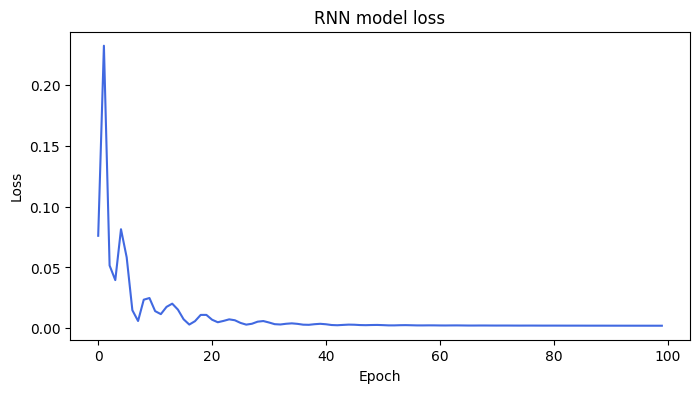

In [22]:
#Training loss for RNN model
rcParams['figure.figsize'] = 8,4
rnn_loss_fig = sns.lineplot(data = train_hist_rnn, color = 'royalblue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RNN model loss")
plt.show(rnn_loss_fig);

In [30]:
from src.lstm import LSTM

In [35]:
#Model specifics
num_input, num_hidden, num_layer, num_output = 1, 4, 1, 1
lstm_model = LSTM(num_input, num_hidden, num_layer, num_output)

In [36]:
#Loss and optimiser functions
num_epochs, lr = 100, 0.1
lstm_criterion = nn.MSELoss(reduction = 'mean')
lstm_updater = torch.optim.Adam(lstm_model.parameters(), lr = lr)

In [37]:
#Training LSTM model
train_hist_lstm = np.zeros(num_epochs)

for epoch in range(num_epochs):
    y_train_pred_lstm = lstm_model(X_train)

    loss = lstm_criterion(y_train_pred_lstm, y_train_lstm)
    train_hist_lstm[epoch] = loss.item()
    if epoch % 5 == 0:
      print("Epoch ", epoch, "MSE: ", loss.item())
    lstm_updater.zero_grad()
    loss.backward()
    lstm_updater.step()

Epoch  0 MSE:  0.1640986204147339
Epoch  5 MSE:  0.04238210245966911
Epoch  10 MSE:  0.030054131522774696
Epoch  15 MSE:  0.01667797937989235
Epoch  20 MSE:  0.007750285789370537
Epoch  25 MSE:  0.004159134812653065
Epoch  30 MSE:  0.002620641840621829
Epoch  35 MSE:  0.0022182317916303873
Epoch  40 MSE:  0.002042845357209444
Epoch  45 MSE:  0.0019202755065634847
Epoch  50 MSE:  0.001957791857421398
Epoch  55 MSE:  0.001901927636936307
Epoch  60 MSE:  0.0018620614428073168
Epoch  65 MSE:  0.0018111057579517365
Epoch  70 MSE:  0.001767496345564723
Epoch  75 MSE:  0.0017493804916739464
Epoch  80 MSE:  0.0017396494513377547
Epoch  85 MSE:  0.0017341099446639419
Epoch  90 MSE:  0.0017280473839491606
Epoch  95 MSE:  0.0017204164760187268


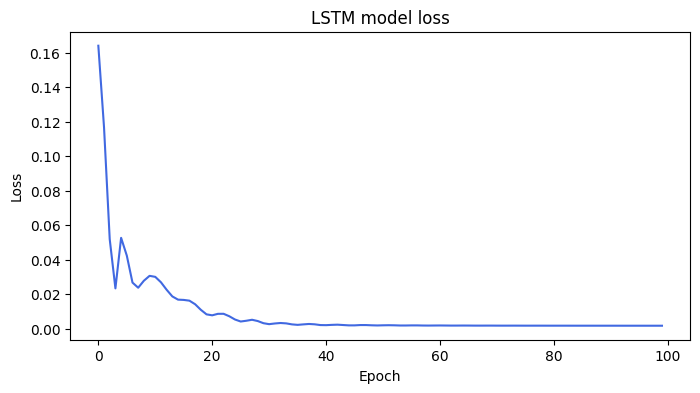

In [38]:
#Training loss for LSTM model
rcParams['figure.figsize'] = 8,4
lstm_loss_fig = sns.lineplot(data = train_hist_lstm, color = 'royalblue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM model loss")
plt.show(lstm_loss_fig);